In [2]:
import sys
sys.path.append('..')
from captum.attr import IntegratedGradients, Saliency, DeepLift
from NNModel import MultiLayerNN
from captum.attr import visualization as viz
import numpy as np
import pickle
import torch
import torch.nn as nn
from prep_data import prep_data
import matplotlib.pyplot as plt

# Data Prep

In [7]:
train_loader, test_loader = prep_data()
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [ ]:
MODEL_PATH = "./data/model.pt"
INCORRECT_PRED_PATH = "./data/incorrect_preds.pkl"
    

state_dict = torch.load(MODEL_PATH, weights_only=True)
new_dict = {}
#When model compiles, all weights are modified from LAYERNAME to _orig_model.LAYERNAME. We remove the _orig_model. for compatibility
for k in state_dict.keys():
    new_dict[k[10:]] = state_dict[k]
model = MultiLayerNN(latent_size=128, num_layers=3)
model.load_state_dict(new_dict)
model.to(device)

with open(INCORRECT_PRED_PATH, "rb") as f:
    incorrect_preds = pickle.load(f)

MultiLayerNN(
  (dim_reduction): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
)

Predicted: 9, True: 3


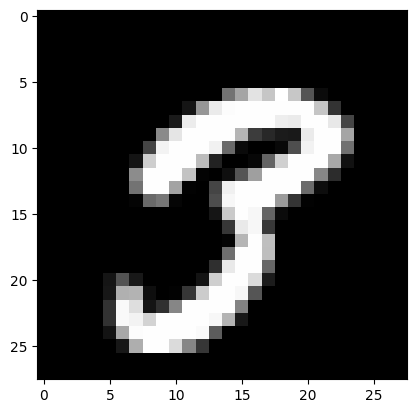

In [ ]:
# Build a mapping from idx to image
# Since train_loader has shuffle=True, we need to get the original dataset
# Also you can do interactively picking
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset

# Create a function to get image by idx
def get_image_by_idx(idx):
    """Get image from dataset by index"""
    if idx < len(train_dataset):
        img, _, _ = train_dataset[idx]
        return img
    else:
        # Adjust index for test set
        test_idx = idx - len(train_dataset)
        img, _, _ = test_dataset[test_idx]
        return img

# Test: visualize first incorrect prediction
first_idx, pred_label, true_label = incorrect_preds[3]
first_img = get_image_by_idx(first_idx)
plt.imshow(first_img.squeeze(), cmap="gray")
print(f"Predicted: {pred_label}, True: {true_label}")

In [14]:
# Get all images for incorrect predictions using the idx
input_imgs = torch.stack([get_image_by_idx(idx) for idx, _, _ in incorrect_preds])
predicted_labels = torch.tensor([pred_label for _, pred_label, _ in incorrect_preds])
true_labels = torch.tensor([true_label for _, _, true_label in incorrect_preds])

# Gradient Attributions

In [15]:
len(incorrect_preds)

1369

In [16]:
ig = IntegratedGradients(model)
final_attributions = torch.zeros_like(input_imgs.squeeze())
for i in range(0, input_imgs.shape[0], 100):
    input_img = input_imgs[i:i+100].to(device)
    labels = predicted_labels.to(device)

    # Get the model's prediction
    output = model(input_img.reshape(-1, 28 * 28))
    pred_probs = nn.functional.softmax(output, dim=1)
    pred_classes = torch.argmax(pred_probs, dim=-1)
    baseline = torch.zeros_like(input_img.reshape(-1, 28*28)).to(device)

    # Calculate attributions using Integrated Gradients
    # The target is the predicted class index
    attributions_ig = ig.attribute(input_img.reshape(-1, 28*28), baselines=baseline, target=pred_classes)
    final_attributions[i:i+100] = attributions_ig.detach().cpu().reshape(-1, 28, 28)
#pred_class = pred_classes[0].item()

# Interactive Single Pick for GradGam

In [ ]:
# Interactive pick - single visualization
# Change j to pick different incorrect predictions (0 to len(incorrect_preds)-1)
j = 0  # Change this value to visualize different predictions

idx, pred_class, true_class = incorrect_preds[j]
original_image = get_image_by_idx(idx)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(original_image.squeeze(), cmap="gray")
im = ax.imshow(final_attributions[j].squeeze().reshape(28, 28).cpu(), cmap="jet", alpha=0.5)
ax.set_title(f"Prediction: {pred_class}, True Label: {true_class}", fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

print(f"Showing incorrect prediction #{j+1}/{len(incorrect_preds)}")
print(f"Image index: {idx}, Predicted: {pred_class}, True: {true_class}")

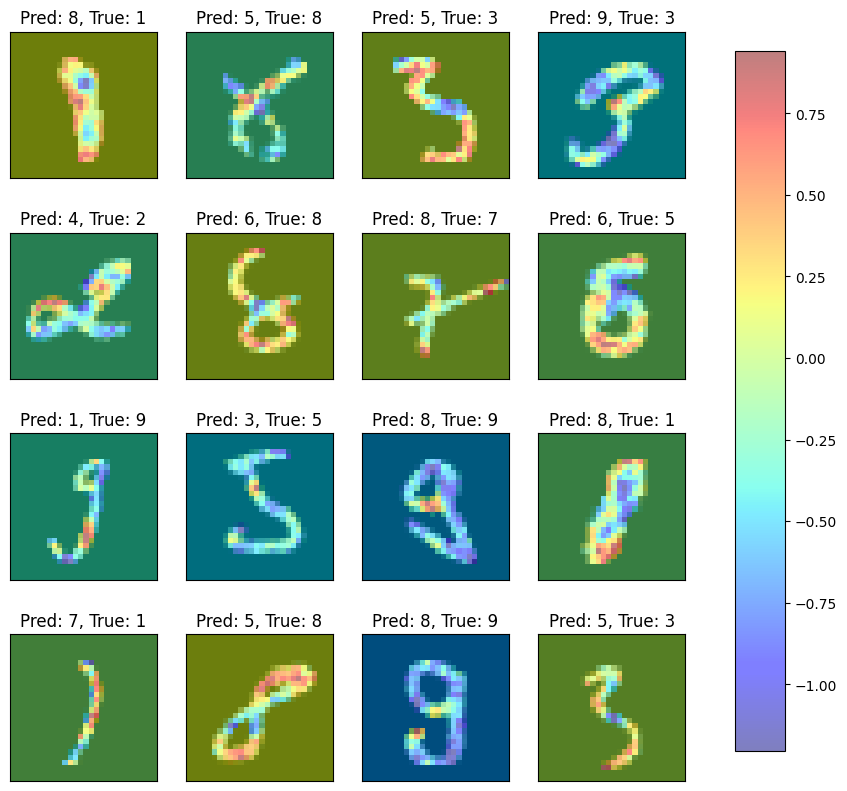

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(16):
    j = i  # allows for "offset views" instead of only the first 16 numbers
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    # Get the image using idx
    idx, pred_class, true_class = incorrect_preds[j]
    original_image = get_image_by_idx(idx)
    
    axes[i].imshow(original_image.squeeze(), cmap="gray")
    im = axes[i].imshow(final_attributions[j].squeeze().reshape(28, 28).cpu(), cmap="jet", alpha=0.5)
    axes[i].set_title(f"Pred: {pred_class}, True: {true_class}")
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)